# 주택 가격 예측: 회귀문제   
## 보스턴 주책 가격 데이터 셋
#### 1970년 중반 보스턴 외과지역 주택가격의 중간 값 예측    
- 지역 1인당 범죄율, 주택 당 평균 방 갯수, 고속도로 접근성, 지방세율 등의 13개의 feature 주어짐 
- Data point가 506개 (404개 train data, 102개 test data)
- 각 feature는 스케일이 서로 다름
- 타겟은 주택의 중간 가격으로 천 달러 단위

In [2]:
%tensorflow_version 2.x

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

import time

In [4]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [5]:
train_data.shape

(404, 13)

In [6]:
test_data.shape

(102, 13)

In [7]:
train_targets # 타겟은 주택의 중간가격으로 천달러 단위 일반적으로 1만달러~5만달러 사이

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Feature 별로 정규화(Normalization) 필요
- 각 특성(입력 data 행렬의 열)에 대해서 특성의 평균을 빼고 표준편차로 나눔 (중앙이 0에 맞춰지고 표준편차가 1이 됨)
- Normalization에 사용한 값은 train data에서 계산한 값 (test data에서 계산한 어떤 값도 넣어서는 안됨)

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /=std

### 모델 구성
- 64개의 unit을 가진 2개의 hidden layer로 네트웍 구성
- 훈련 데이터의 갯수가 적을수록 overfitting이 더 쉽게 일어나므로 작은 모델을 사용하여 overfitting을 피하고자 함


In [21]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


### [PPT] Loss function, K-fold cross-validation

### K-fold cross-validation

##### 100 epoch으로 훈련

In [25]:
import numpy as np

k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    #검증 data 준비: K 번째 분할
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate ([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate ([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()

    model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size=1, verbose=1)

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [26]:
all_scores

[2.003192186355591, 2.7374298572540283, 2.5417087078094482, 2.5280556678771973]

In [27]:
np.mean(all_scores)

2.452596604824066

#### 500 epoch으로 훈련
- 훈련하면서 mae 점수 평균을 계산하고 그래프로 나타냄

In [33]:
from keras import backend as K
# 메모리 해제
K.clear_session()

In [41]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드#', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] #검증 data 준비, K 번째 분할
    val_targets = train_targets[i * num_val_samples: (i +1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]], axis=0)

    model = build_model()
    history=model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae'] #val_mean_absolute_error에서  KeyError 발생 --> model compile 할때 표현에 맞춰서 val_mae로 변경
    all_mae_histories.append(mae_history)


처리중인 폴드# 0
처리중인 폴드# 1
처리중인 폴드# 2
처리중인 폴드# 3


In [42]:
all_scores

[2.003192186355591, 2.7374298572540283, 2.5417087078094482, 2.5280556678771973]

In [43]:
np.mean(all_scores)

2.452596604824066

###모든 폴드에 대해 epoch의 mae 점수 평균을 계산

In [44]:
average_mae_history=[np.mean([X[i] for X in all_mae_histories]) for i in range(num_epochs)]

### 그래프로 나타냄

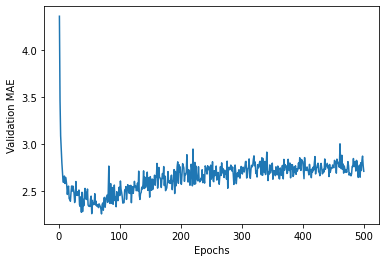

In [45]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history) +1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

###그래프의 범위가 크고 변동이 심하기 때문에 보기 쉽게 바꿈
- 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 data point를 제외
- 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동평균(exponential moving average)으로 대체
- 지수이동 평균은 시계열 데이터를 부드럽게 만드는 기법 중 하나. 코드6번째 줄에서 이전에 계산된 이동 평균에 factor를 곱하고 현재 포인트에 (1-factor)를 곱해 합산한 것

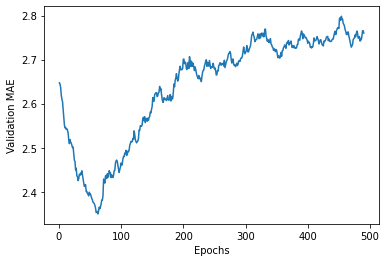

In [46]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
          if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1-factor))
          else:
                smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


- 80번째 epoch 이후 감소하지 않음. 이 지점 이후로는 overfitting 시작
- 여기까지는 매개변수 튜닝을 위한 과정. 이후 과정에서는 모든 훈련 데이터를 사용하고 최상의 매개변수를 적용하여 모델을 훈련 시키고 test data로 성능을 확인 

In [47]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 17.7059 - mae: 2.6836


In [48]:
test_mae_score

2.6835782527923584